In [1]:
#imported libraries
import numpy as np
import random
import math
import matplotlib.pyplot as plt

## Question 1

### Generating plots for fig 2.2

In [3]:
#functions used

#used to generate numbers from a gaussian of specified mean and variance
def gen_number(mean,variance):
    return random.gauss(mean,math.sqrt(variance))


#used to run a uniform bernouli for and epsilon value
#pick greedy if 0 is returned else uniform from other arms
def eps_greedy(eps):
    return 1 if random.random() < eps else 0

#picking uniformly **excluding greedy one**
#returns arm index to be picked
def uni_pick(greedy):
    # opts = set([i for i in range(10)])
    # opts.remove(greedy)
    # opts = list(opts)
    opts = [i for i in range(10)]
    return opts[random.randint(0,9)]

#picking greedy one
#returns arm index to be picked
def greedy_pick(est):
    return est.index(max(est))

#pick new arm
def new_arm(eps,est):
    grd_pick = greedy_pick(est)
    choice = eps_greedy(eps)
    if choice:
        return uni_pick(greedy=grd_pick)
    else:
        return grd_pick


#generate absolute diff
#returns a list of absolute differences that we will replace in the errors list vertically depending on step
def abs_error(tru,est):
    return [abs(tru[i] - est[i]) for i in range(10)]


#update estimate given which arm was picked and how many time that arm has been picked, assume arm track is updated prior to this
def upd_est(est,arm,reward,arm_track):
    est[arm] += (reward - est[arm])/arm_track[arm]


#updates error for a given step number 
def upd_error(errors,abs_error,step):
    #for each arm
    for i in range(10):
        #for that particular step
        errors[i][step] += abs_error[i]


#averages out the errors
def error_avg(errors,exps):
    #for each arm
    for i in range(10):
        for j in range(len(errors[i])): #1000 ususally
            errors[i][j] /= exps

#averages out the rewards
def reward_avg(rewards,exps):
    for j in range(len(rewards)): #1000 ususally
        rewards[j] /= exps

#averages out the optcount
def optcnt_avg(opt_count,exps):
    for j in range(len(opt_count)): #1000 ususally
        opt_count[j] /= exps

def plot_avg_rew(rewards,exps,num_steps):
    reward_avg(rewards=rewards,exps=exps)
    x_values = [i for i in range(num_steps)]
    plt.figure(figsize=(15, 5))  # Optional: Set the size of the plot
    plt.plot(rewards)  # Plot x and y values
    plt.xlabel('Steps (0 to 999)')
    plt.ylabel('Average Reward')
    plt.title('Plot of Average Reward against Steps')
    plt.grid(True)  # Optional: Add a grid to the plot
    # plt.xscale('log')
    plt.show()

def plot_avg_opt(opt_count,exps,num_steps):
    optcnt_avg(opt_count=opt_count,exps=exps)
    x_values = [i for i in range(num_steps)]
    plt.figure(figsize=(15, 5))  # Optional: Set the size of the plot
    plt.plot(opt_count)  # Plot x and y values
    plt.xlabel('Steps (0 to 999)')
    plt.ylabel('Average Optimal Ratio')
    plt.title('Plot of Average Optimal Ratio against Steps')
    plt.grid(True)  # Optional: Add a grid to the plot
    plt.show()

def plot_avg_error(errors,exps,num_steps):
    error_avg(errors=errors,exps=exps)
    x_values = [i for i in range(num_steps)]
    plt.figure(figsize=(12, 6))
    
    for i in range(len(errors)):
        plt.plot(x_values, errors[i], label=f'Arm {i}')

    # Adding labels and title
    plt.xlabel('Steps')
    plt.ylabel('Average Error')
    plt.title('Average Error of Each Arm Over Time')
    plt.legend()  # Show legend with labels
    plt.grid(True)  # Optional: Show grid
    plt.tight_layout()
    plt.show()

#take a random walk from normal distribution ussually from an equal starting point
def upd_arm_tru(arm_tru,mean,std_dev):
    for i in range(10): 
        arm_tru[i] += random.gauss(mean,std_dev) 

#update the estimates but using a constant step size and not sample mean
def upd_est_css(est,arm,reward,arm_track,alpha):
    est[arm] += alpha*(reward - est[arm])

#new arm selection using ucb
def new_arm_ucb(est,step,arm_track,const = 2):
    grd_pick = greedy_pick(est)
    pick = 0
    maxp = 0
    for i in range(10):
        if arm_track[i] == 0:
            pick = i
            break
        calc = est[i] + (const * math.sqrt(math.log(step)/arm_track[i]))
        if calc > maxp:
            pick = i
            maxp = calc
    return pick

#softmax
def softmax(hueristics):
    exp_values = [math.exp(h) for h in hueristics]
    total = sum(exp_values)
    probs = [exp_val / total for exp_val in exp_values]
    
    return probs

#updating heuristics
def upd_huer(hueristics,curr_arm,alpha,reward,baseline):
    probs = softmax(hueristics=hueristics)
    for i in range(10):
        if i == curr_arm:
            hueristics[i] += alpha*(reward-baseline)*(1-probs[i])
        else:
            hueristics[i] -= alpha*(reward-baseline)*probs[i]

#picking a new arm based on heuristic
def new_arm_hue(hueristics):
    probs = softmax(hueristics)

    chosen_arm = random.choices(range(len(hueristics)), weights=probs, k=1)[0]
    return chosen_arm

In [4]:
class BanditSimulation:
    def __init__(self, num_arms=10, num_steps=1000, num_experiments=2000, epsilon=0.01, variance=1, eps_var=False):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.eps = epsilon
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.eps_var = eps_var

    def run_experiments(self):
        for exp in range(self.num_experiments):
            # Select expected values for the 10 arms from a normal distribution
            arm_tru = [gen_number(0, self.variance) for _ in range(self.num_arms)]
            
             
            opt = greedy_pick(arm_tru)
            
             
            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
             
            curr_arm = random.randint(0, self.num_arms - 1)
            
            for step in range(self.num_steps):
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1
                
                #update estimates of the arm
                upd_est(est=arm_est, arm=curr_arm, reward=reward, arm_track=arm_track)
                
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)
                
                #choose the next arm using an epsilon-greedy strategy
                #update epsilon if necessary
                if self.eps_var:
                    self.eps = self.eps/(step+1)
                curr_arm = new_arm(eps=self.eps, est=arm_est)

### Fig 2.2 Plots along with average absolute estimation error

#### Eps = 0.01

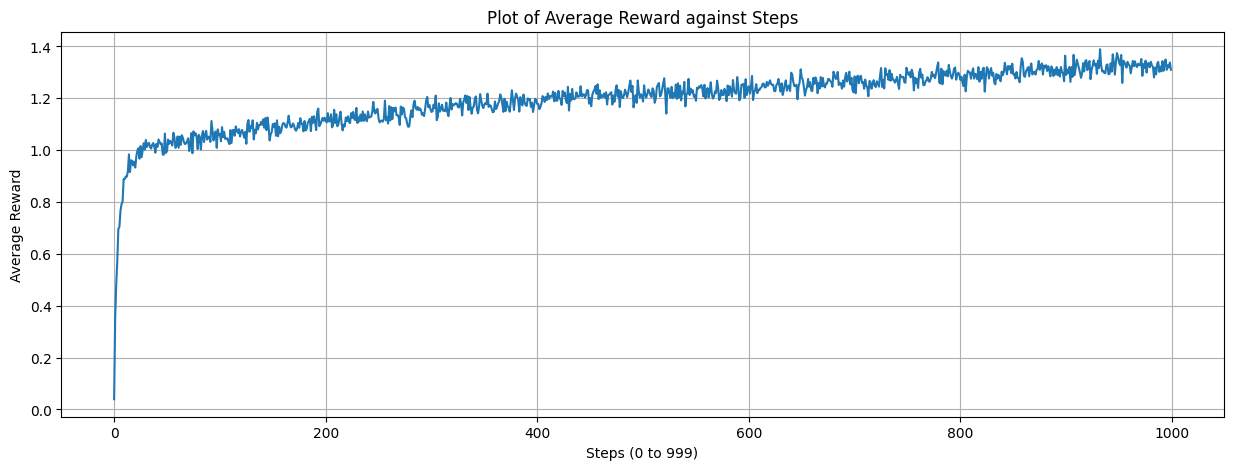

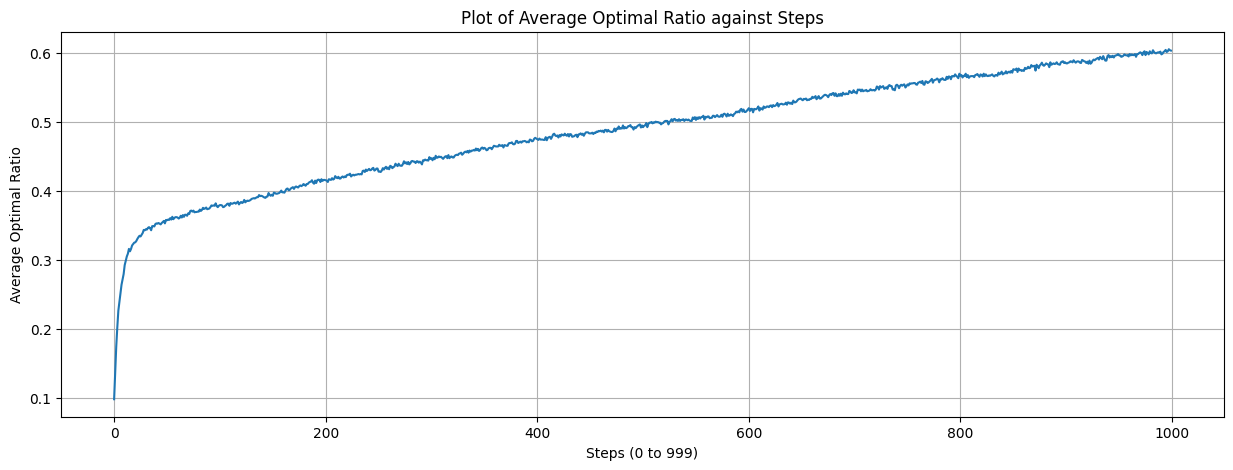

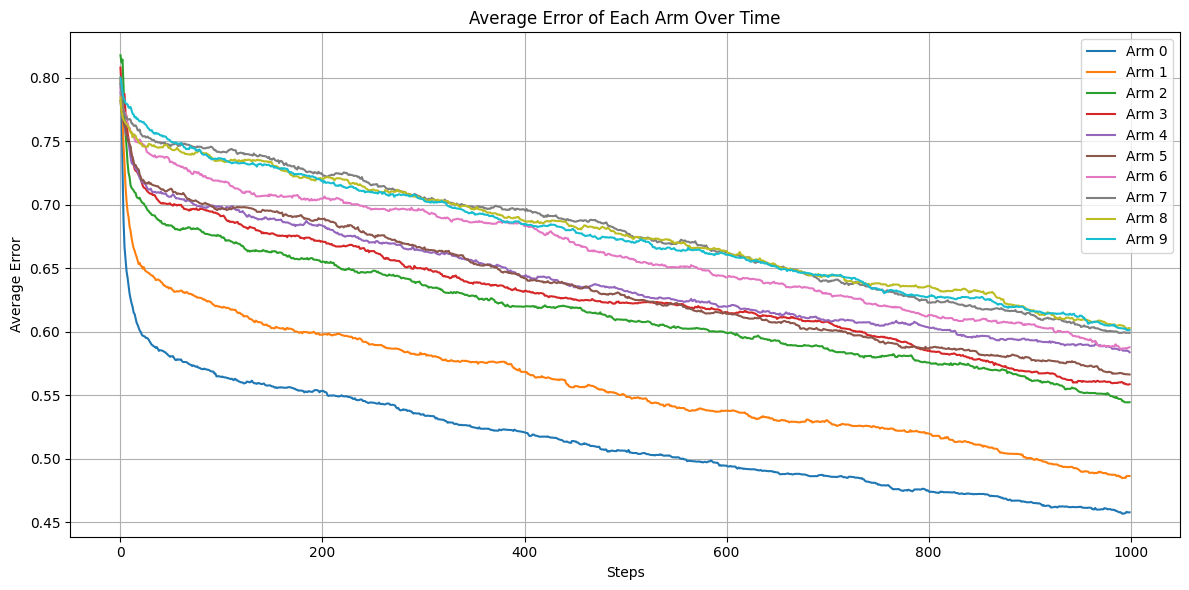

In [5]:
simulation = BanditSimulation()
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

#### Eps = 0.1

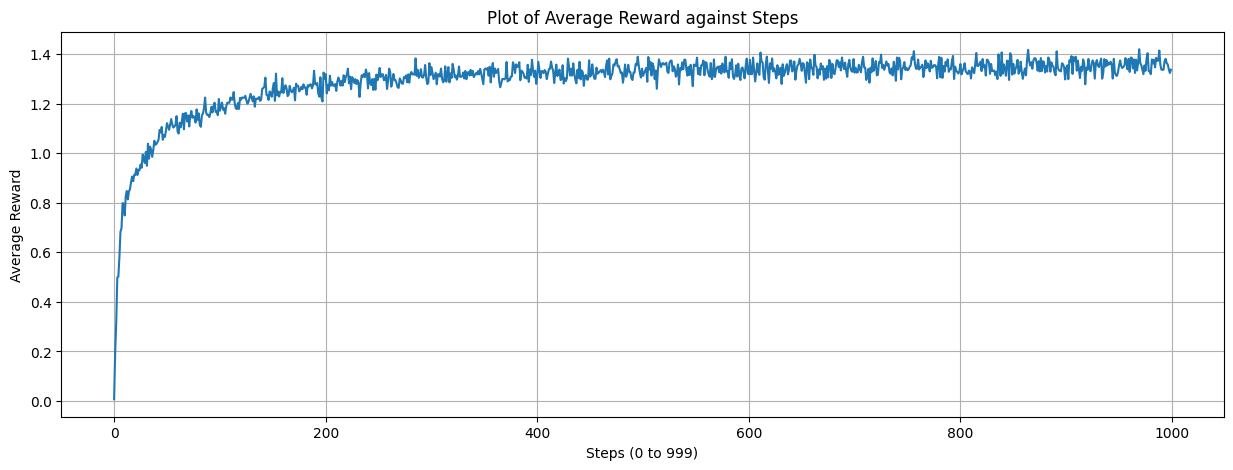

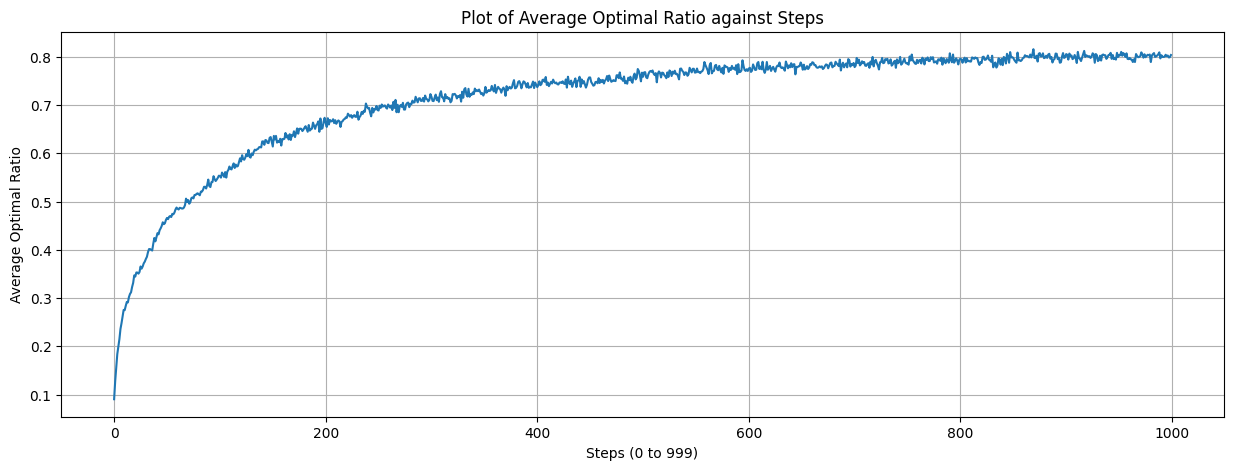

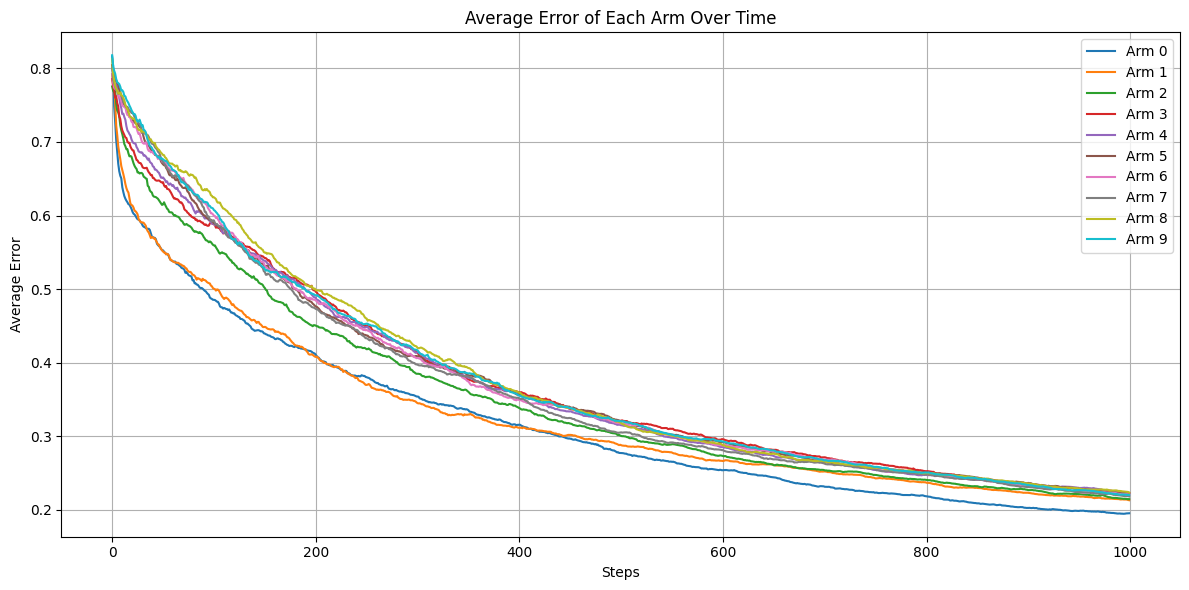

In [6]:
simulation = BanditSimulation(epsilon=0.1)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

#### Eps = 0.0

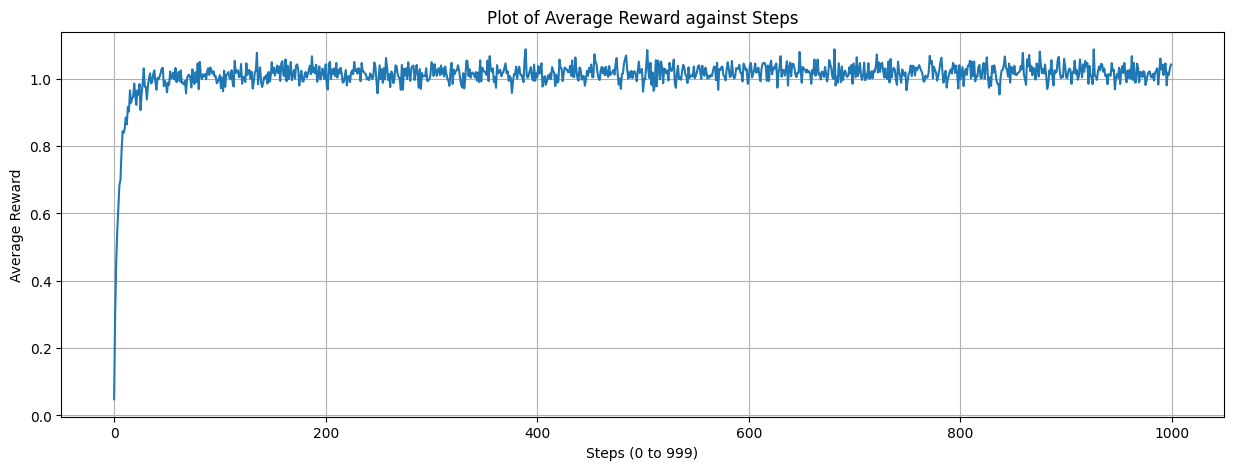

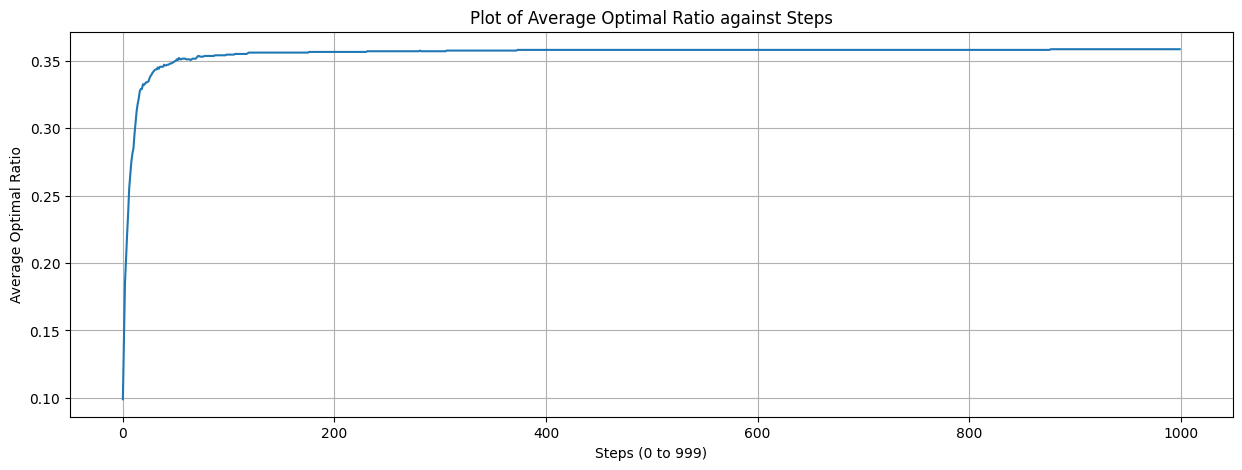

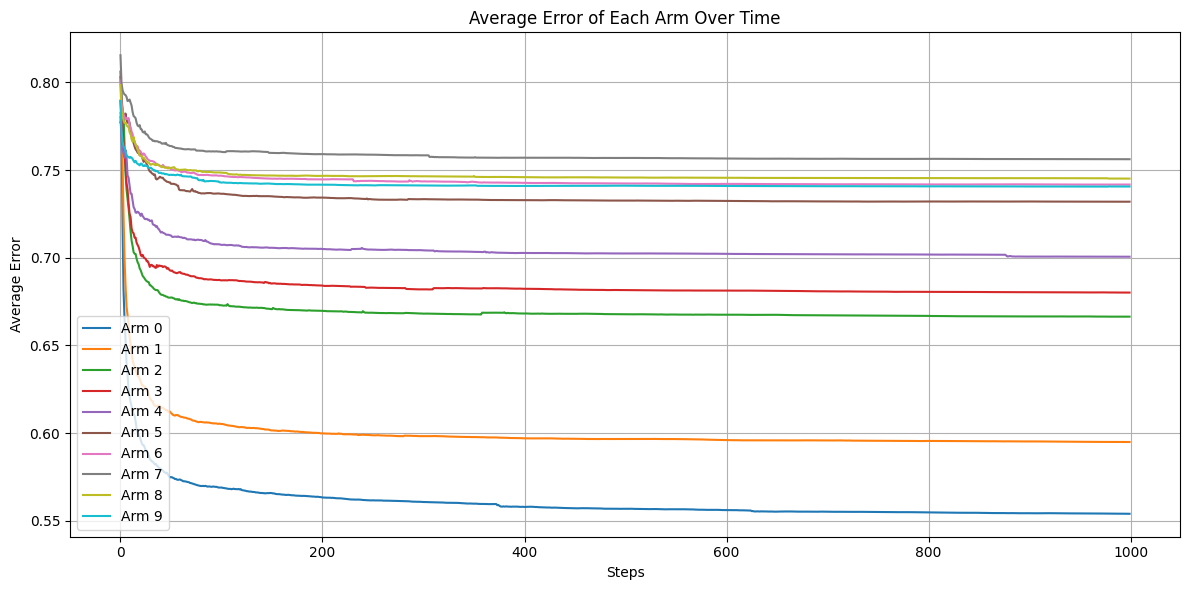

In [7]:
simulation = BanditSimulation(epsilon=0)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)


#### Eps = 0.1 but time varying

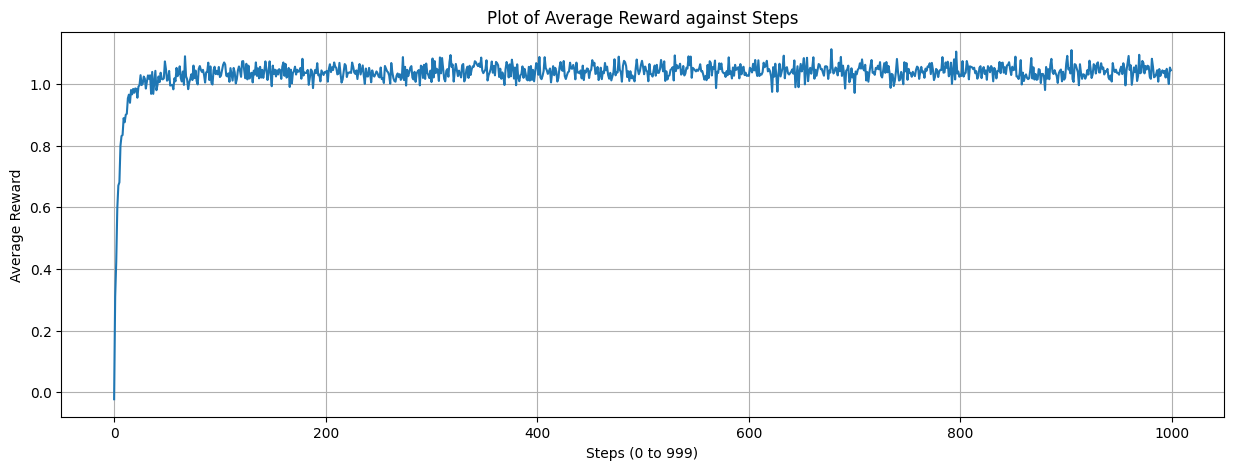

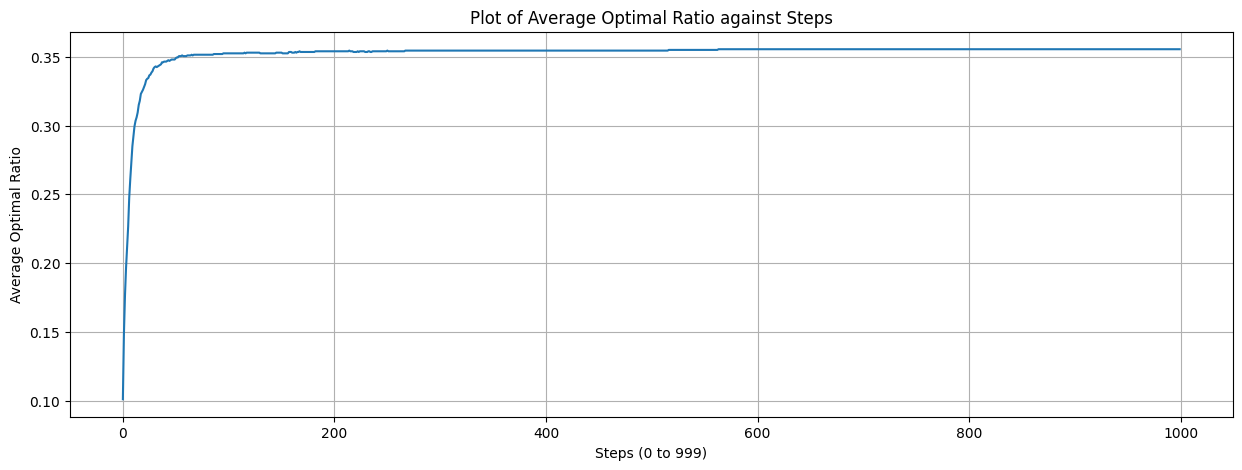

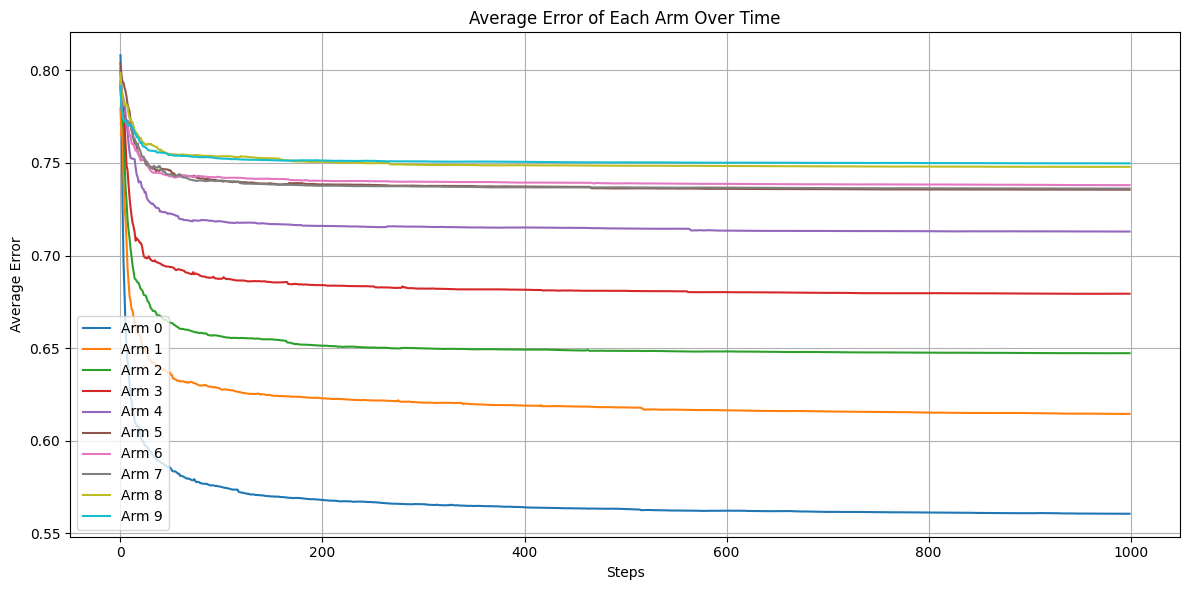

In [8]:
simulation = BanditSimulation(epsilon=0.1,eps_var=True)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

## Question 2

#### For epsilon = 0.01

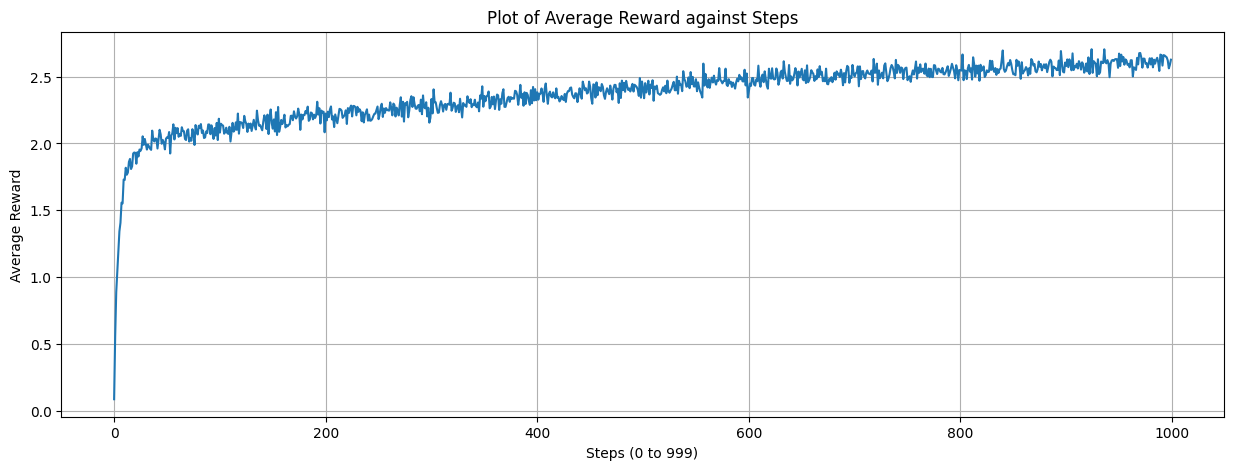

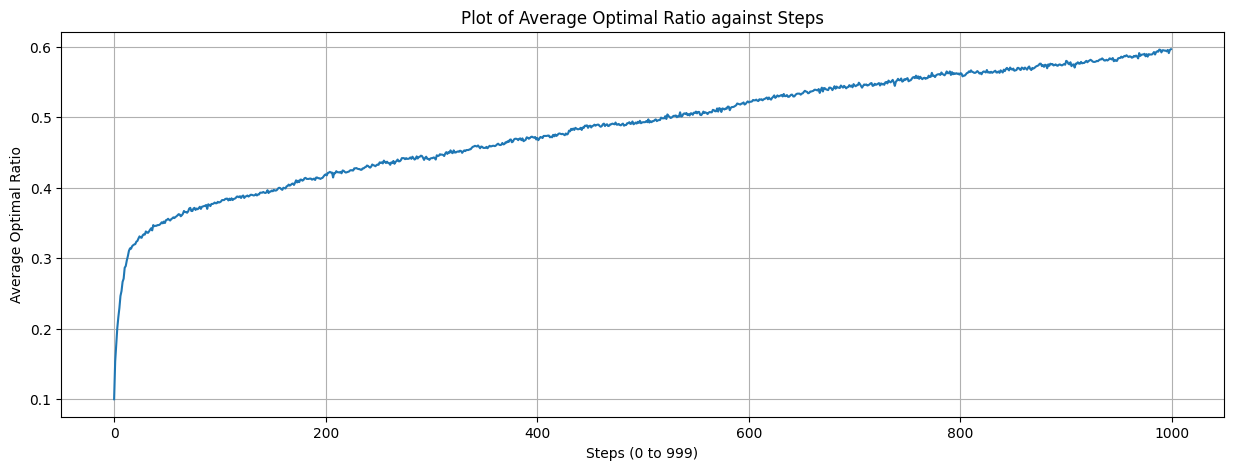

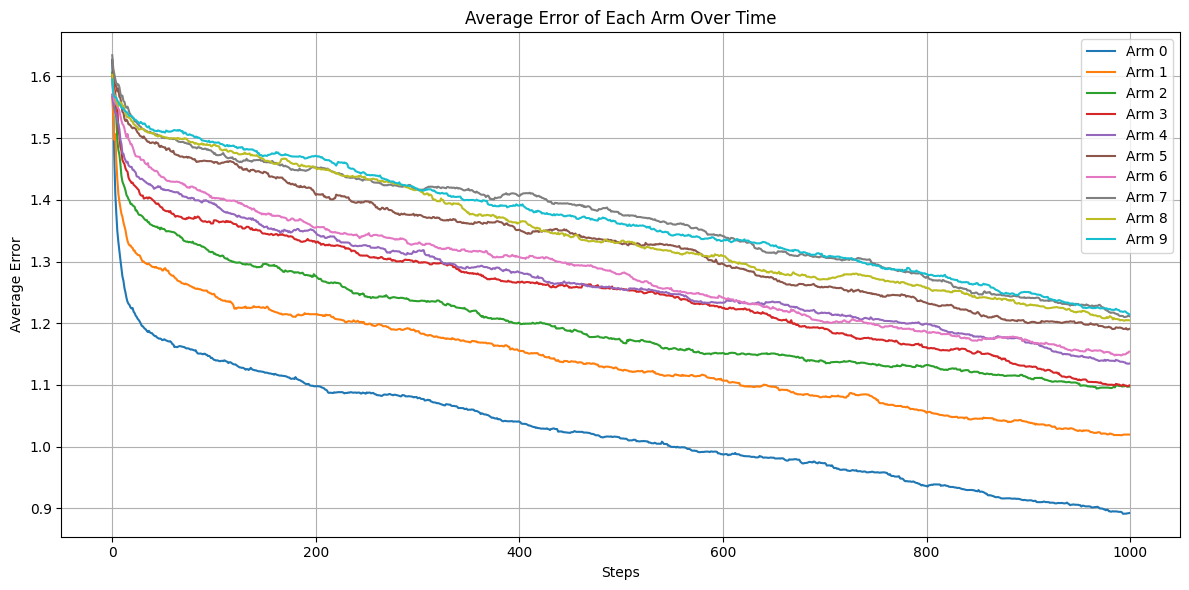

In [9]:
simulation = BanditSimulation(variance=4)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

#### For epsilon = 0.1

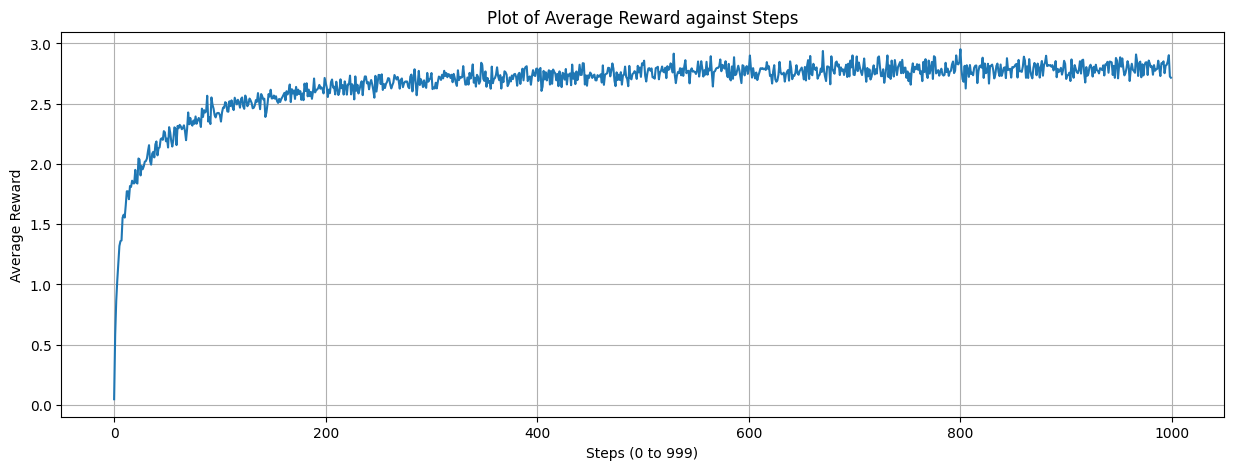

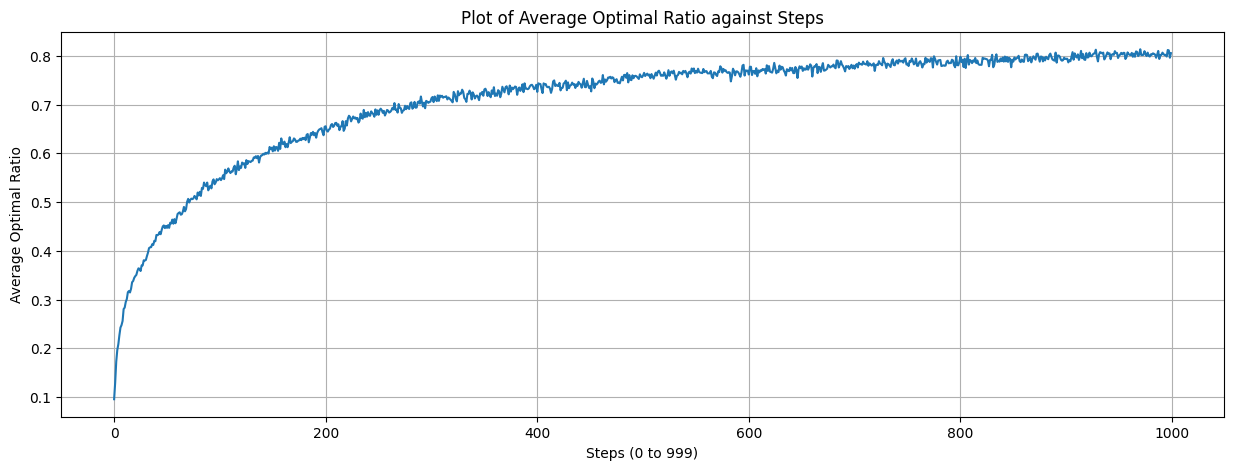

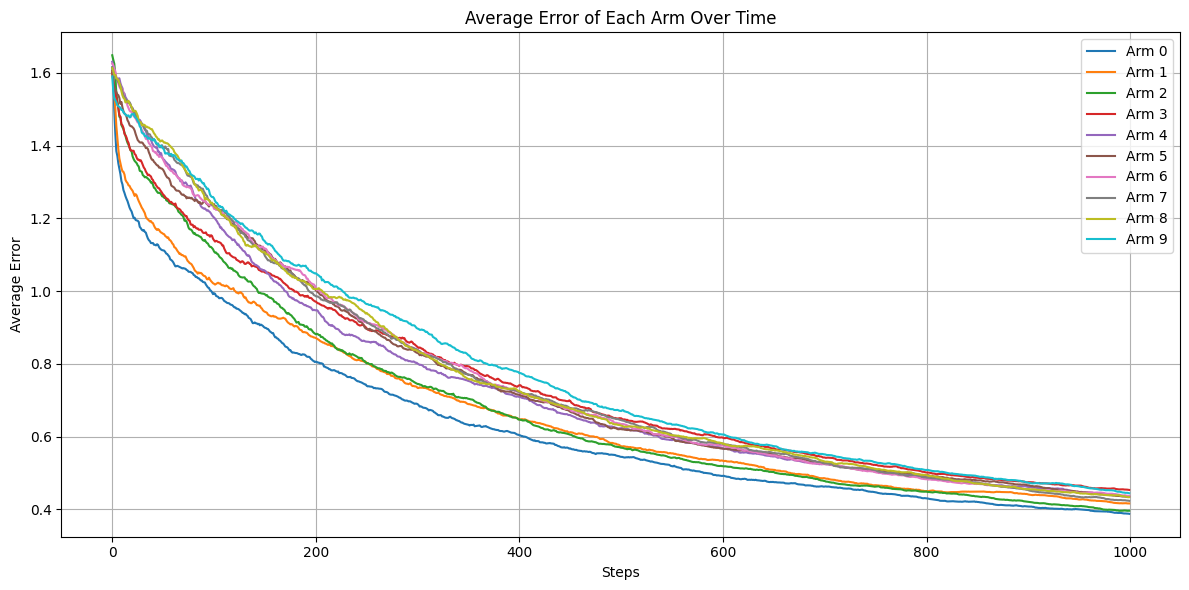

In [10]:
simulation = BanditSimulation(epsilon=0.1, variance=4)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

#### For epsilon = 0.0

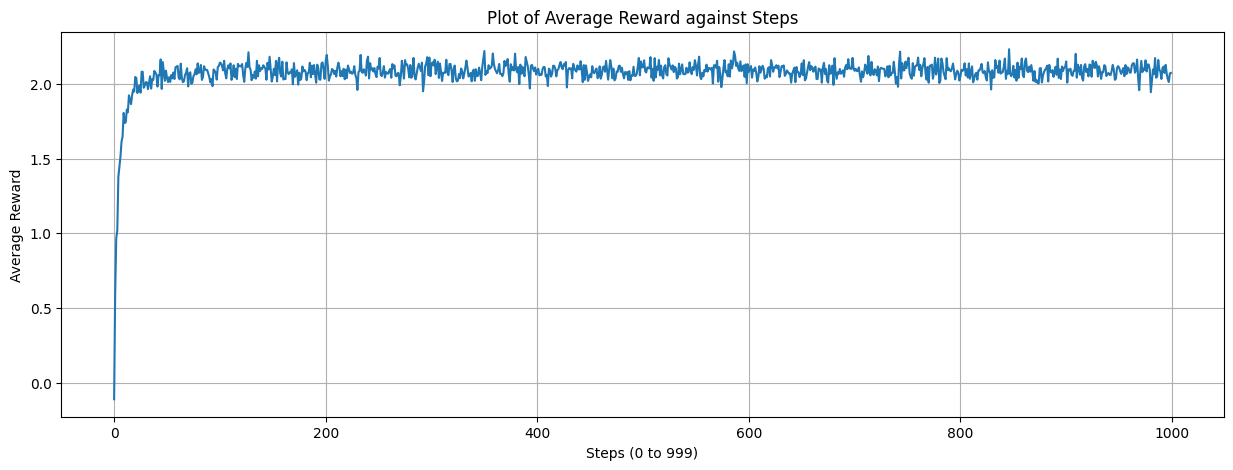

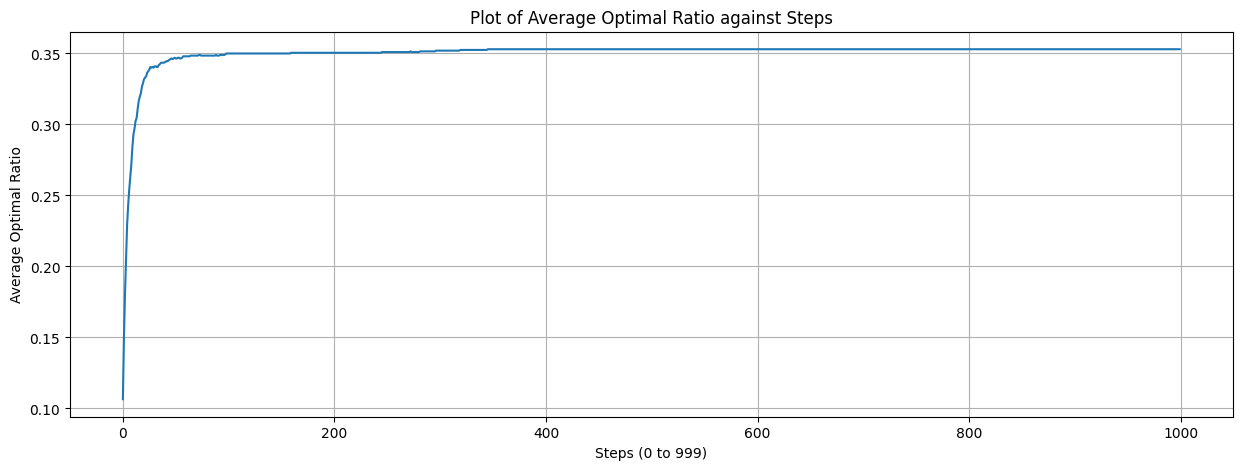

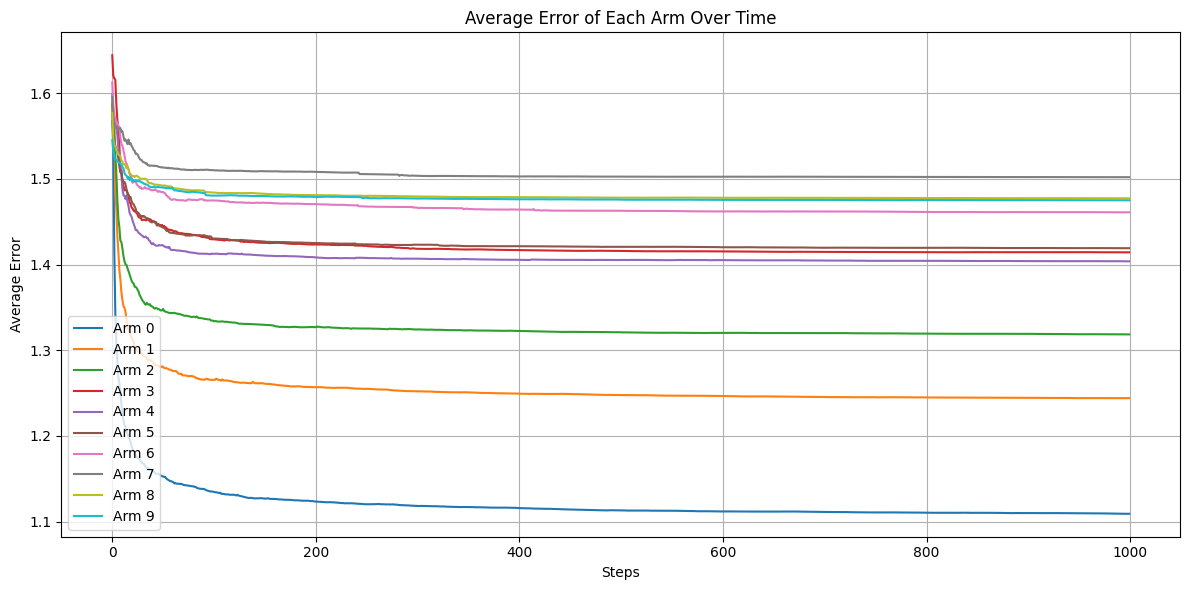

In [11]:
simulation = BanditSimulation(epsilon=0, variance=4)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

#### For epsilon = 0.1 but time varying

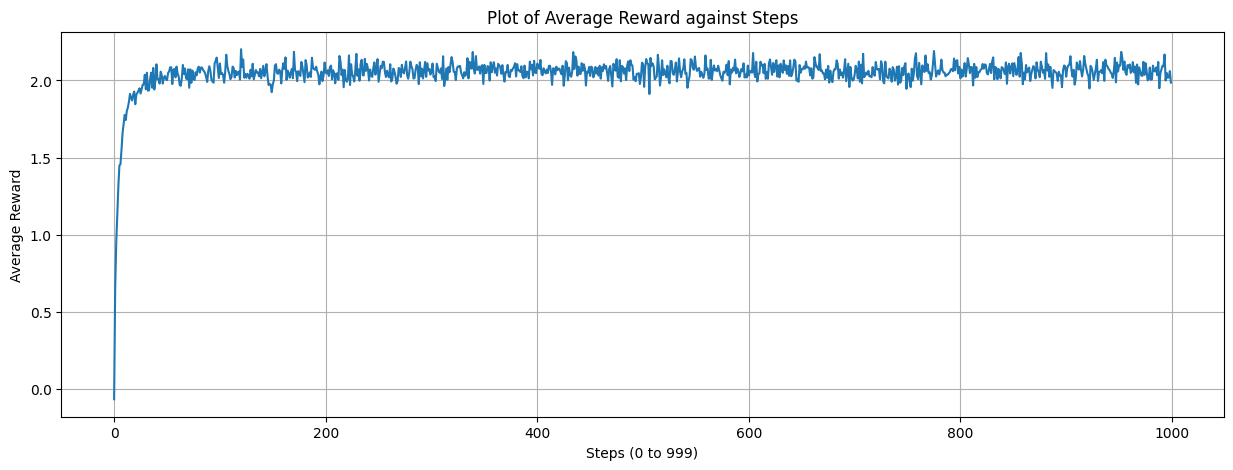

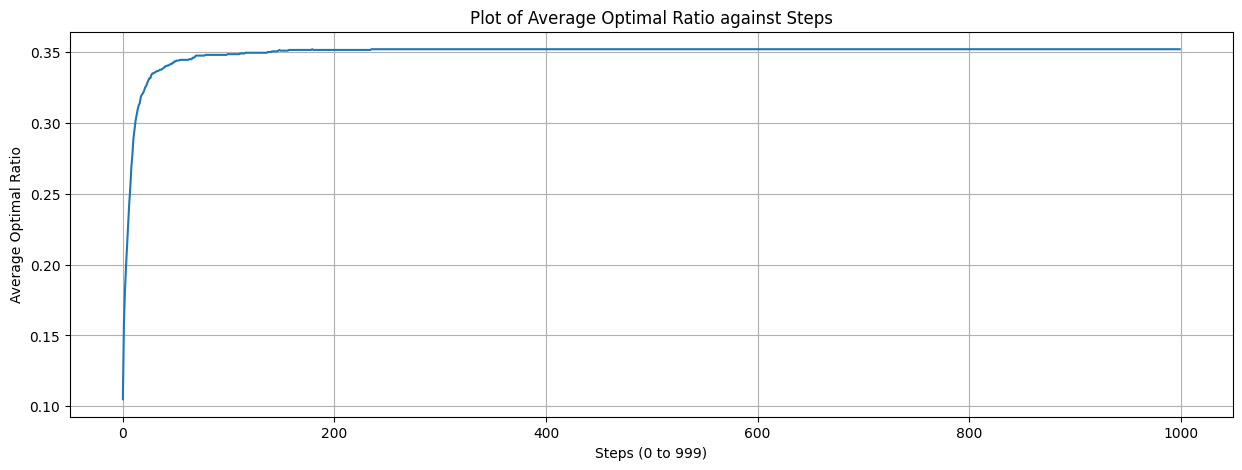

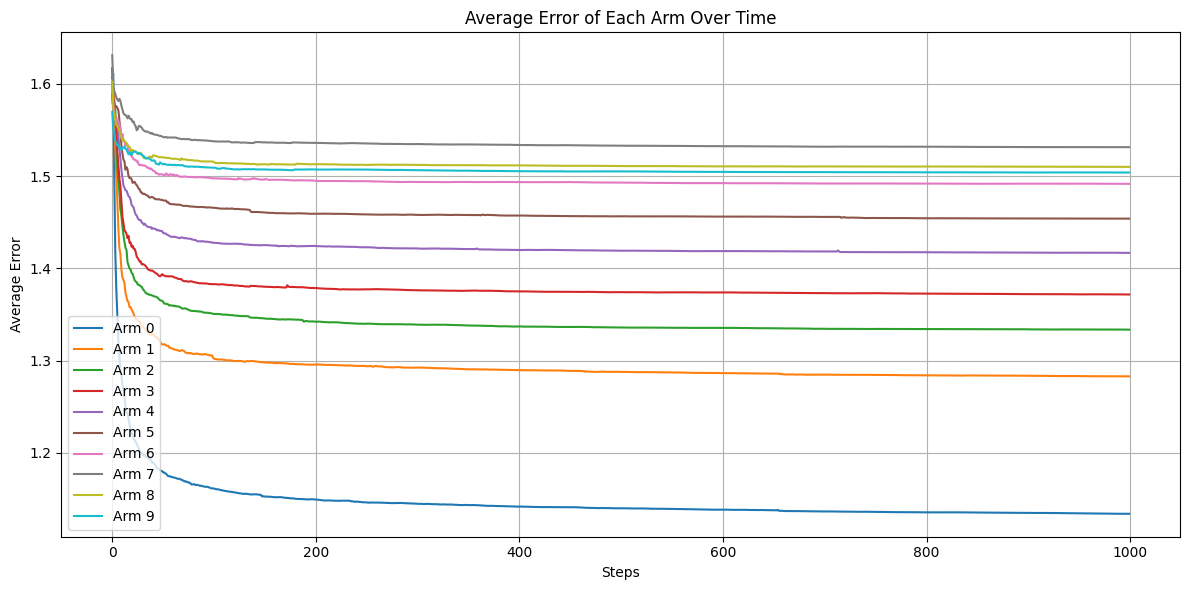

In [12]:
simulation = BanditSimulation(epsilon=0.1, variance=4, eps_var=True)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

# Question 5

## Non Stationary Problems

### Action Method : Sample Mean

In [18]:
class BanditSimulationNonStat:
    def __init__(self, num_arms=10, num_steps=10000, num_experiments=2000, epsilon=0.01, variance=1, eps_var=False):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.eps = epsilon
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.eps_var = eps_var

    def run_experiments(self):
        for exp in range(self.num_experiments):

            arm_tru = [0]*10

            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
             
            curr_arm = random.randint(0, self.num_arms - 1)
            
            for step in range(self.num_steps):                
                 
                opt = greedy_pick(arm_tru)
                
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                    
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1
                
                #update estimates of the arm
                upd_est(est=arm_est, arm=curr_arm, reward=reward, arm_track=arm_track)
                
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)
                
                #update the true values using random walk
                upd_arm_tru(arm_tru=arm_tru,mean=0,std_dev=0.01)
                
                #choose the next arm using an epsilon-greedy strategy
                #update epsilon if necessary
                if self.eps_var:
                    self.eps = self.eps/(step+1)
                curr_arm = new_arm(eps=self.eps, est=arm_est)


#### For Epsilon = 0.1

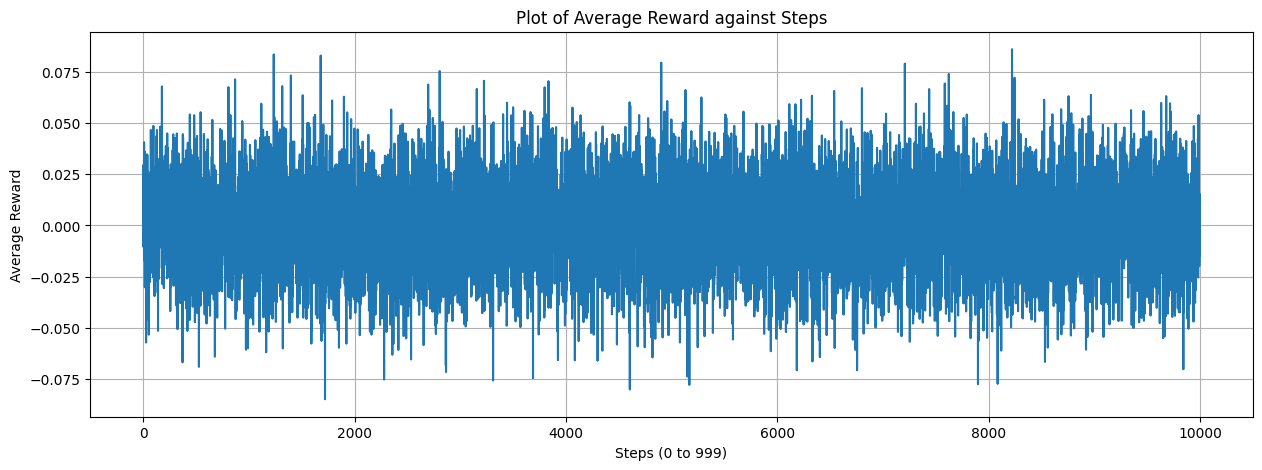

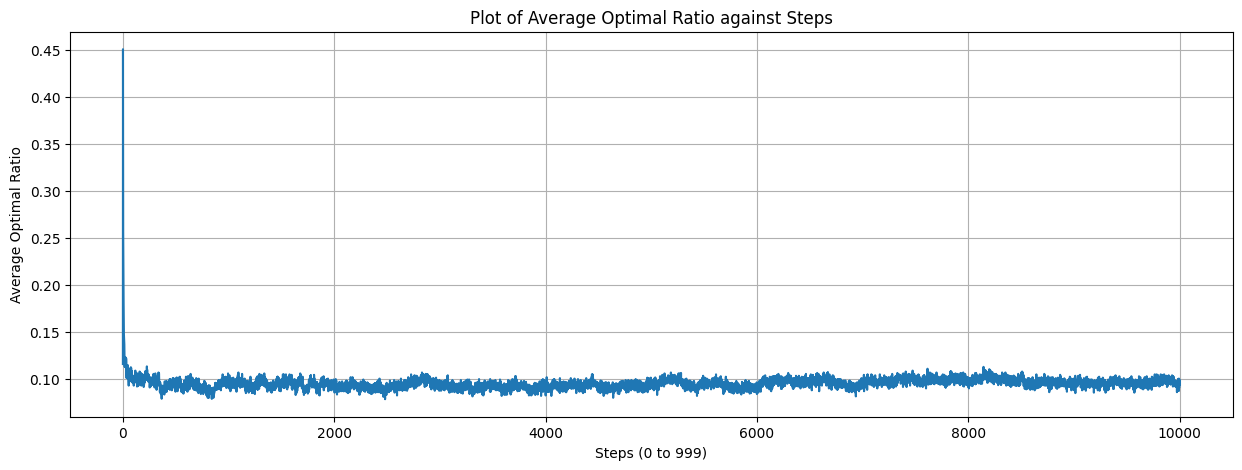

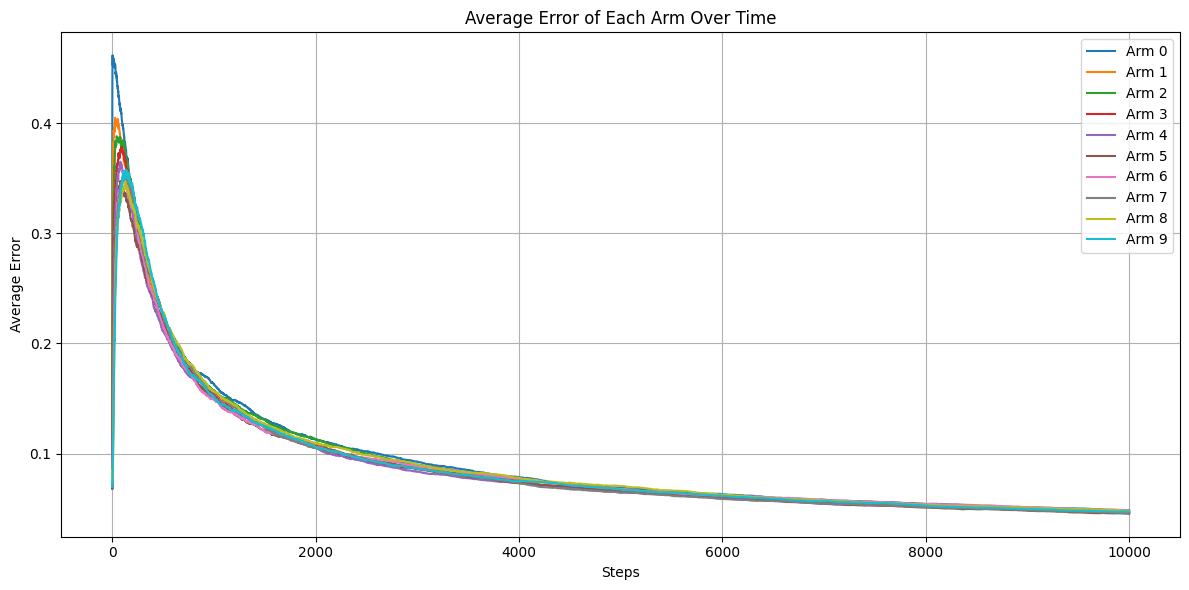

In [19]:
simulation = BanditSimulationNonStat(epsilon=0.1)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

### Action Method : Constant Step Size

In [22]:
class BanditSimulationNonStatConstStep:
    def __init__(self, num_arms=10, num_steps=10000, num_experiments=2000, epsilon=0.01, variance=1, eps_var=False, alpha = 0.1,alpha_var = False):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.eps = epsilon
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.eps_var = eps_var
        self.alpha = alpha
        self.alpha_var = alpha_var

    def run_experiments(self):
        for exp in range(self.num_experiments):
             
            arm_tru = [gen_number(0, self.variance)]*10

             
            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
             
            curr_arm = random.randint(0, self.num_arms - 1)
            
            for step in range(self.num_steps):                
                 
                opt = greedy_pick(arm_tru)
                
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1
                
                #update estimates of the arm
                upd_est_css(est=arm_est, arm=curr_arm, reward=reward, arm_track=arm_track,alpha=self.alpha)

                #update alpha if needed
                if self.alpha_var:
                    self.alpha = self.alpha/step+1
                    
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)
                
                #choose the next arm using an epsilon-greedy strategy
                upd_arm_tru(arm_tru=arm_tru,mean=0,std_dev=0.01)

                #update epsilon if necessary
                if self.eps_var:
                    self.eps = self.eps/(step+1)
                curr_arm = new_arm(eps=self.eps, est=arm_est)


#### For Epsilon=0.1

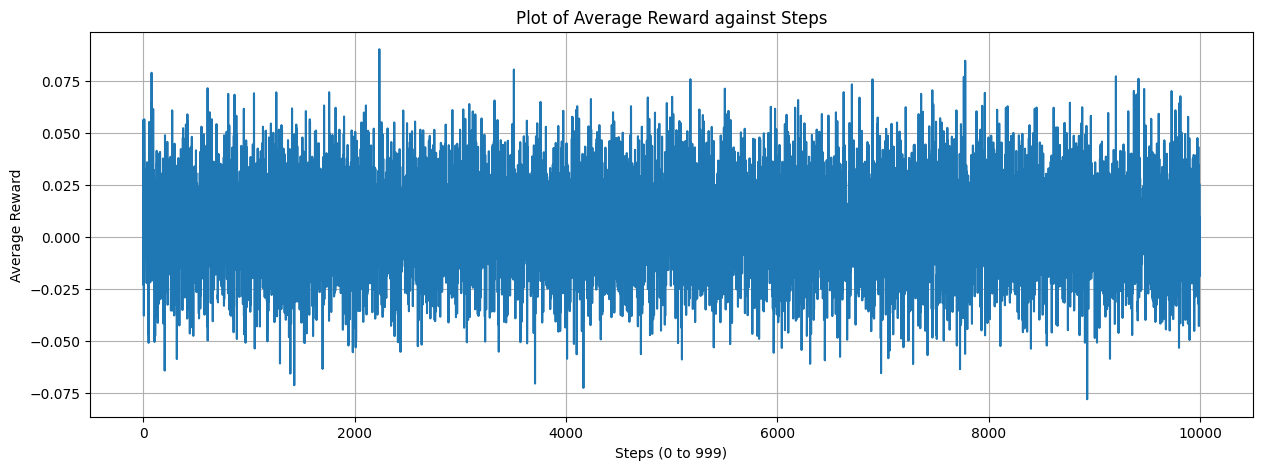

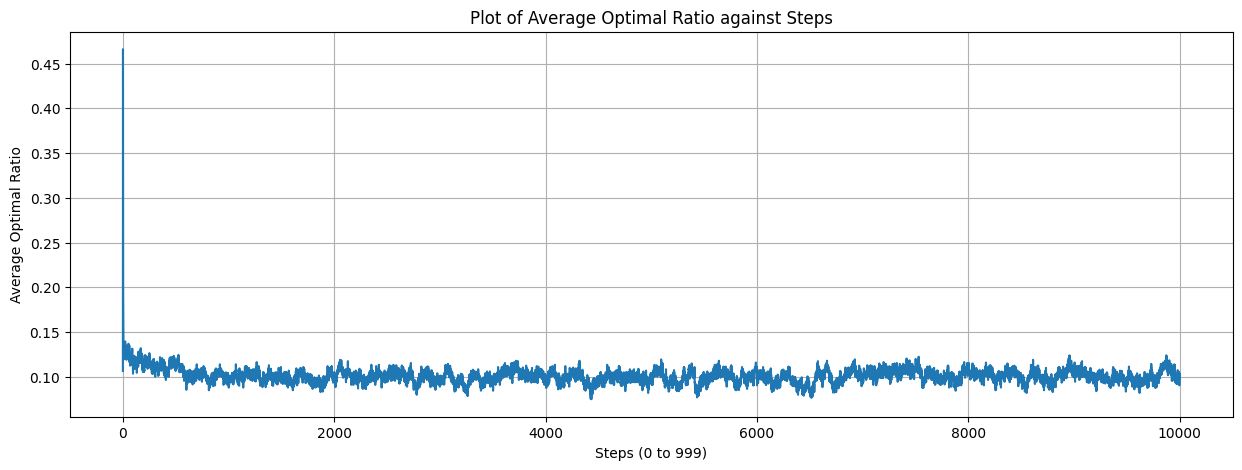

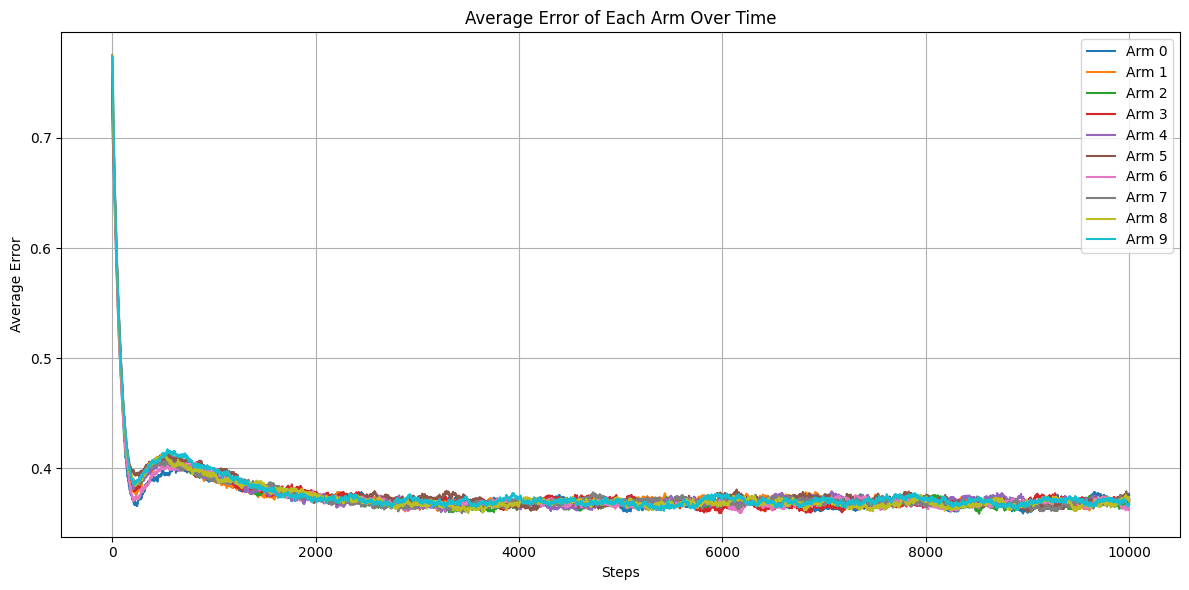

In [23]:
simulation = BanditSimulationNonStatConstStep(epsilon=0.1)
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)

# Question 6

In [18]:
class BanditSimulation_CSS_UCB:
    def __init__(self, num_arms=10, num_steps=1000, num_experiments=2000, epsilon=0.01, variance=1, eps_var=False, alpha = 0.1,alpha_var = False, const = 2):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.eps = epsilon
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.eps_var = eps_var
        self.alpha = alpha
        self.alpha_var = alpha_var
        self.const = const

    def run_experiments(self):
        for exp in range(self.num_experiments):
            #select expected values for the 10 arms from a normal distribution all the same initially
            arm_tru = [gen_number(0, self.variance) for i in range(10)]

            #optimal arm for this set of expected values
            opt = greedy_pick(arm_tru)

            #track arm selections and initial estimates
            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
            #picking a random arm
            curr_arm = random.randint(0, self.num_arms - 1)
            
            for step in range(self.num_steps):                
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1
                
                #update estimates of the arm
                upd_est_css(est=arm_est, arm=curr_arm, reward=reward, arm_track=arm_track,alpha=self.alpha)

                #update alpha if needed
                if self.alpha_var:
                    self.alpha = self.alpha/step+1
                    
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)
                
                # #update tru values of arm
                # upd_arm_tru(arm_tru=arm_tru,mean=0,std_dev=0.01)

                #choose the next arm using an epsilon-greedy strategy
                #update epsilon if necessary
                if self.eps_var:
                    self.eps = self.eps/(step+1)
                curr_arm = new_arm_ucb(est=arm_est,step=step+1,arm_track=arm_track,const=self.const)


In [19]:
class BanditSimulation_UCB:
    def __init__(self, num_arms=10, num_steps=1000, num_experiments=2000, epsilon=0.01, variance=1, eps_var=False, alpha = 0.1,alpha_var = False, const = 2):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.eps = epsilon
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.eps_var = eps_var
        self.alpha = alpha
        self.alpha_var = alpha_var
        self.const = const

    def run_experiments(self):
        for exp in range(self.num_experiments):
             
            arm_tru = [gen_number(0, self.variance) for i in range(10)]

             
            opt = greedy_pick(arm_tru)

             
            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
             
            curr_arm = random.randint(0, self.num_arms - 1)
            
            for step in range(self.num_steps):                
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1
                
                #update estimates of the arm
                upd_est(est=arm_est,arm_track=arm_track,arm=curr_arm,reward=reward)

                #update alpha if needed
                if self.alpha_var:
                    self.alpha = self.alpha/step+1
                    
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)
                
                # #update tru values of arm
                # upd_arm_tru(arm_tru=arm_tru,mean=0,std_dev=0.01)

                #choose the next arm using an epsilon-greedy strategy
                #update epsilon if necessary
                if self.eps_var:
                    self.eps = self.eps/(step+1)
                curr_arm = new_arm_ucb(est=arm_est,step=step+1,arm_track=arm_track,const=self.const)


#### for Epsilon = 0.1, C = 2, alpha = 0.1

UCB with Const = 2


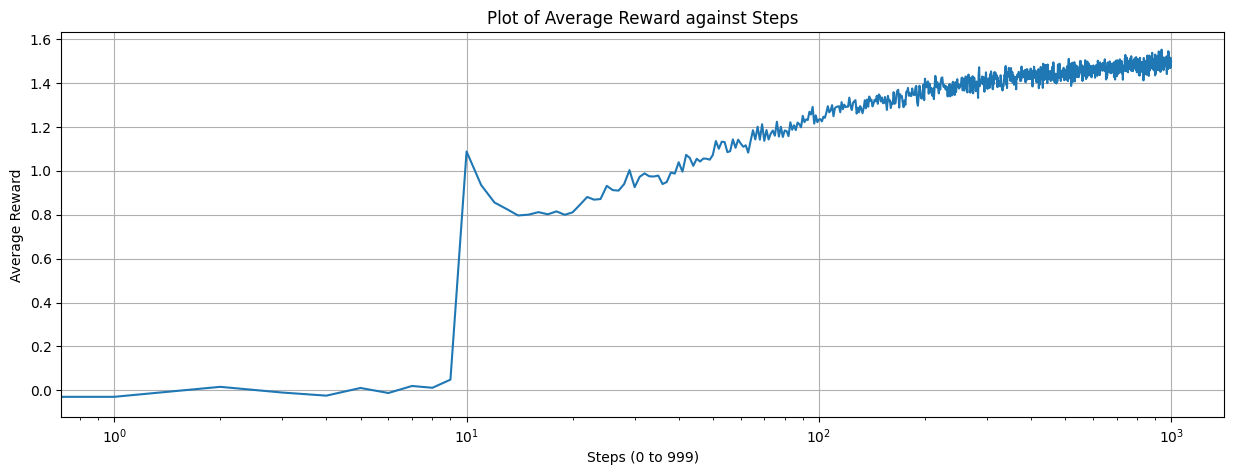

NameError: name 'BanditSimulation' is not defined

In [20]:
simulation = BanditSimulation_UCB()
simulation.run_experiments()
print("UCB with Const = 2")
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)
# plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)
# plot_avg_error(simulation.errors,simulation.num_experiments,simulation.num_steps)
simulation = BanditSimulation(epsilon=0.1)
print("E-greedy with E = 0.1")
simulation.run_experiments()
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)

UCB with Const = 1


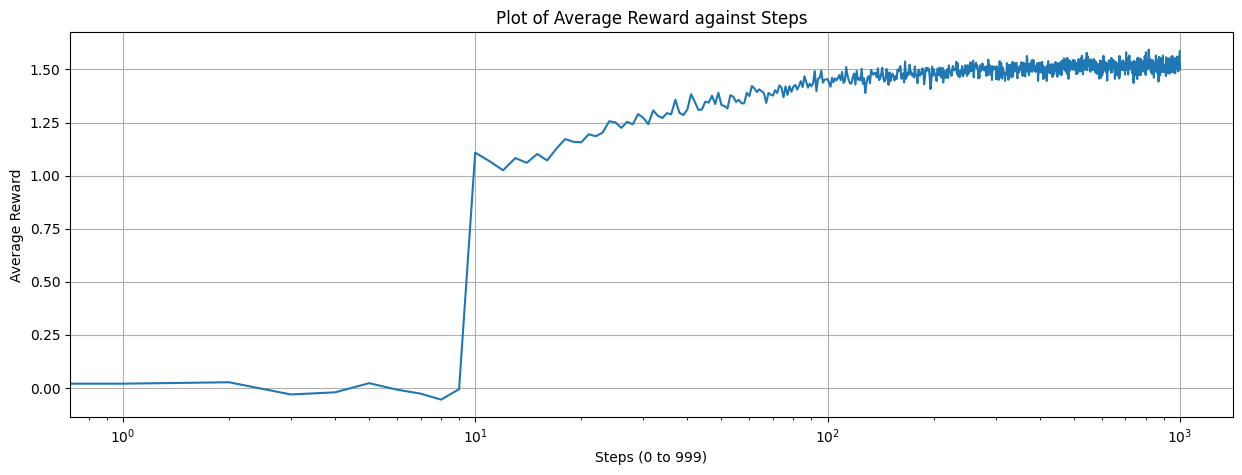

UCB with Const = 4


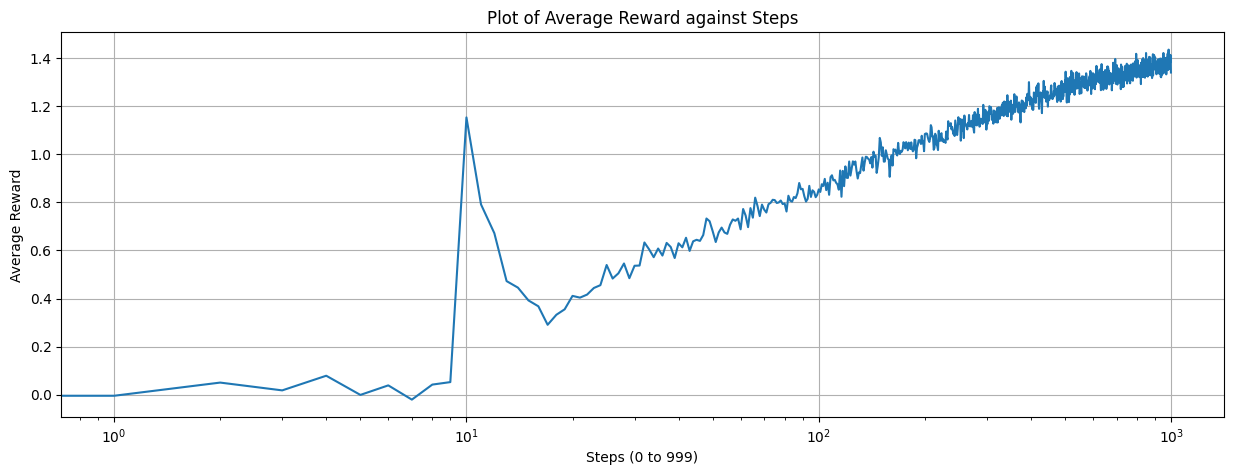

In [21]:
simulation = BanditSimulation_UCB(const=1)
simulation.run_experiments()
print("UCB with Const = 1")
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)

simulation = BanditSimulation_UCB(const=4)
simulation.run_experiments()
print("UCB with Const = 4")
plot_avg_rew(simulation.rewards,simulation.num_experiments,simulation.num_steps)

# Question 7

In [41]:
class BanditSimulation_CSS_GB:
    def __init__(self, num_arms=10, num_steps=1000, num_experiments=2000, variance=1, alpha = 0.1,alpha_var = False, baseline_var = False):
        self.num_arms = num_arms
        self.variance = variance
        self.num_steps = num_steps
        self.num_experiments = num_experiments
        self.rewards = [0] * num_steps
        self.errors = [[0] * num_steps for _ in range(num_arms)]
        self.opt_count = [0] * num_steps
        self.alpha = alpha
        self.alpha_var = alpha_var
        self.baseline = 0
        self.baseline_var = baseline_var

    def run_experiments(self):
        for exp in range(self.num_experiments):
            # Select expected values for the 10 arms from a normal distribution
            arm_tru = [gen_number(4, self.variance) for _ in range(self.num_arms)]

             
            arm_track = [0] * self.num_arms
            arm_est = [0] * self.num_arms
            
             
            curr_arm = random.randint(0, self.num_arms - 1)

            #huertics initialised as zeros
            heuristics = [0]*10

             
            opt = greedy_pick(arm_tru)
            
            for step in range(self.num_steps):                
                
                #check if arm was optimal
                if curr_arm == opt:
                    self.opt_count[step] += 1
                    
                #get reward from the chosen arm
                reward = gen_number(mean=arm_tru[curr_arm], variance=self.variance)
                self.rewards[step] += reward
                
                #update arm selection count
                arm_track[curr_arm] += 1

                #update heuristics
                upd_huer(hueristics=heuristics,curr_arm=curr_arm,alpha=self.alpha,reward=reward,baseline=self.baseline)

                #update baseline if at all
                if self.baseline_var:
                    self.baseline = (self.baseline*step + reward)/(step+1)
                
                #update estimates of the arm
                upd_est_css(est=arm_est, arm=curr_arm, reward=reward, arm_track=arm_track,alpha=self.alpha)

                #update alpha if needed
                if self.alpha_var:
                    self.alpha = self.alpha/(step+1)
                    
                #find and update absolute error
                absol_error = abs_error(arm_tru, arm_est)
                upd_error(errors=self.errors, abs_error=absol_error, step=step)

                curr_arm = new_arm_hue(hueristics=heuristics)


GB with Alpha = 0.1 and no baseline


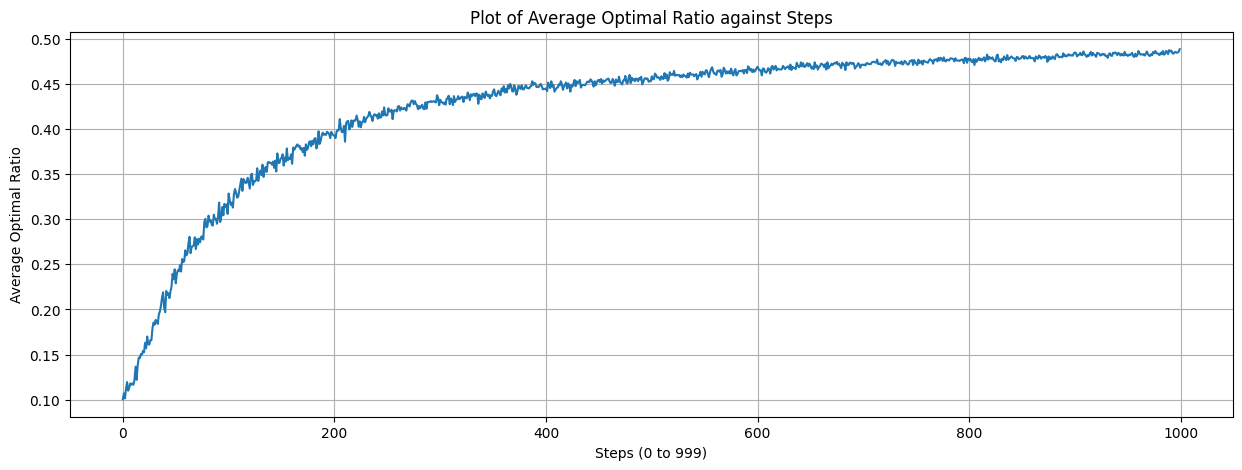

GB with Alpha = 0.1 and baseline


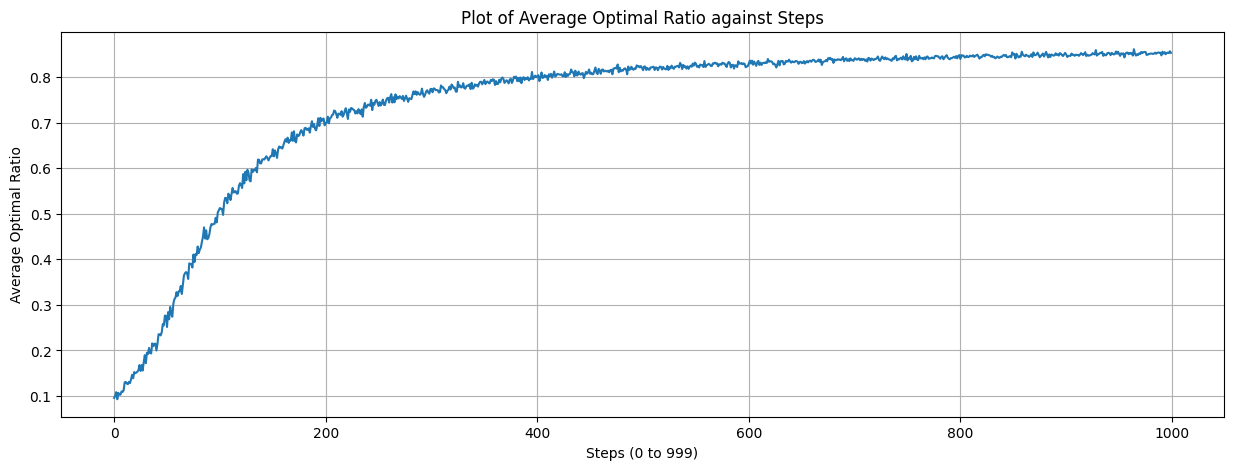

In [50]:
simulation = BanditSimulation_CSS_GB(alpha=0.1)
simulation.run_experiments()
print("GB with Alpha = 0.1 and no baseline")
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)

simulation = BanditSimulation_CSS_GB(alpha=0.1,baseline_var=True)
simulation.run_experiments()
print("GB with Alpha = 0.1 and baseline")
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)


GB with Alpha = 0.4 and no baseline


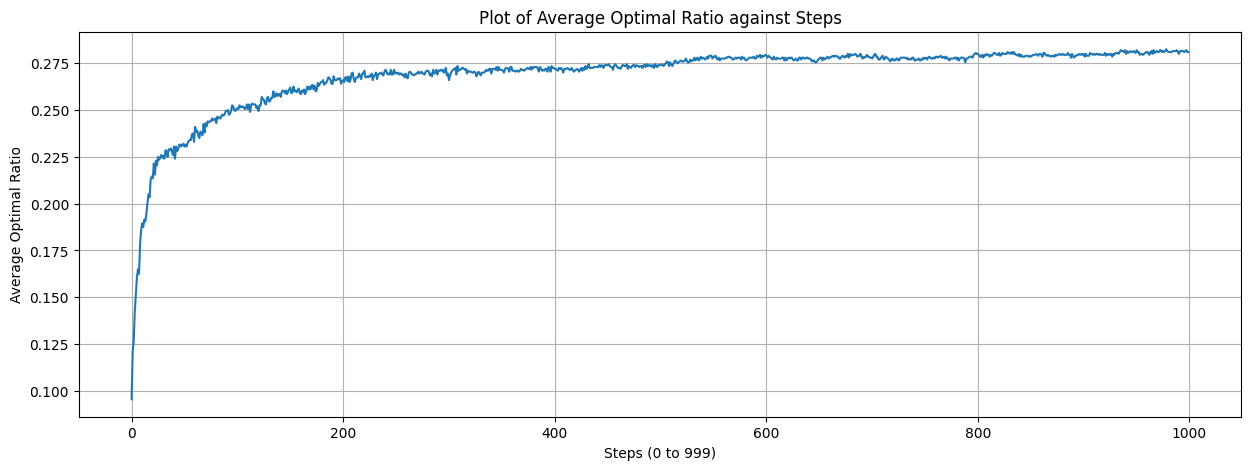

GB with Alpha = 0.4 and baseline


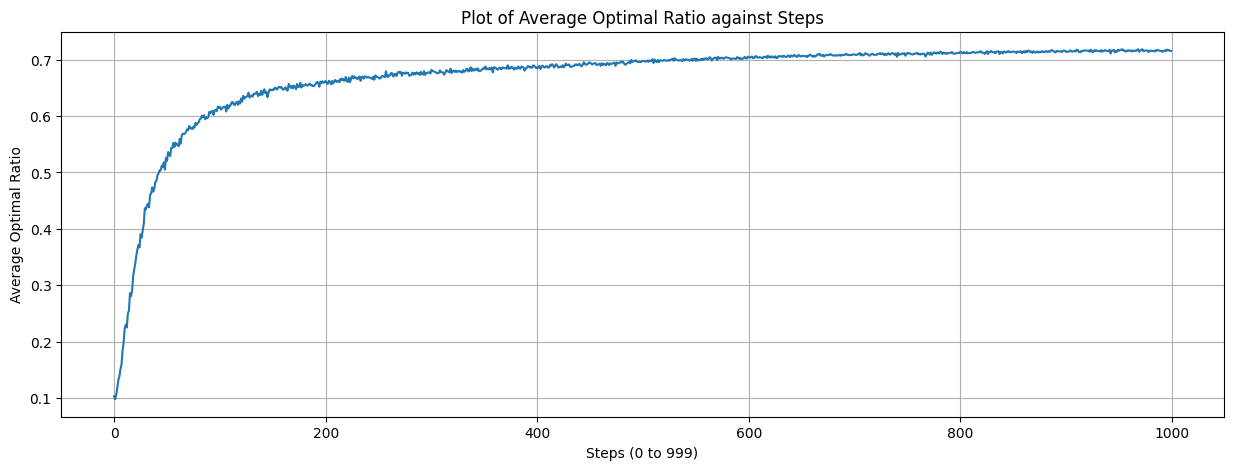

In [51]:
simulation = BanditSimulation_CSS_GB(alpha=0.4)
simulation.run_experiments()
print("GB with Alpha = 0.4 and no baseline")
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)

simulation = BanditSimulation_CSS_GB(alpha=0.4,baseline_var=True)
simulation.run_experiments()
print("GB with Alpha = 0.4 and baseline")
plot_avg_opt(simulation.opt_count,simulation.num_experiments,simulation.num_steps)